In [1]:
import os
os.environ["ESMFMKFILE"] = "/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/esmf.mk"
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import xarray as xr
import scipy
from scipy import special
from scipy.stats import norm
from scipy.stats import ks_2samp as ks_2samp
import sys 
import xesmf as xe 
import cartopy.feature as cfeature
import cftime
from netCDF4 import Dataset
from netCDF4 import num2date
import dask.array as da
from dask.array import apply_gufunc
import montecarlo_functions as mf
import time
from joblib import Parallel, delayed

In [32]:
# Common parameters to the three resolutions
W=5

if W > 3: 
    W_EMO5 = 4
else : 
    W_EMO5 = W 

    
D = 'his'

do_plot = D 

root_dir = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/'
fig_dir = f'{root_dir}/scripts/python_2/plotter/hws/figures' 


boundaries = np.array([1,16.9,40.5,50]) ; min_lon,max_lon,min_lat,max_lat = boundaries

to_tit = ['HWs mean Tmax', 'HWs max Tmax', 'HWs persistence', 'HWMId',
          'HWs mean HFLS','HW evap. deficit','HWs count']

clabs=["°C","°C","days","HWMId","W/m^2","Evap. deficit","N."]

variables=['HW_mean_tmax','HW_max_tmax','HW_persistence','HW_HWMI',
           'HW_mean_hfls','HW_hfls_deficit','HW_number']

var = variables[W]

variables_to_tit = ['HWs mean Tmax', 'HWs max Tmax', 'HWs persistence', 'HWMId',
                    'HW mean hfls','HW evap. deficit','HWs number'] 

var_to_tit = variables_to_tit[W]

execute_array_his = ['ds_his.HW_mean_tmax','ds_his.HW_max_tmax','ds_his.HW_persistence',
                     'ds_his.HW_HWMI','ds_his.HW_mean_hfls','ds_his.HW_hfls_deficit',
                     'ds_his.HW_number']

execute_array_rcp85 = ['ds_rcp85.HW_mean_tmax','ds_rcp85.HW_max_tmax','ds_rcp85.HW_persistence',
                       'ds_rcp85.HW_HWMI','ds_rcp85.HW_mean_hfls','ds_rcp85.HW_hfls_deficit',
                       'ds_rcp85.HW_number']


if do_plot == 'his' :
        
        cmin =        [ 15,  15,   3,   4,   10,  0,     0  ]
        cmax =        [ 40,  42,   7,  13,  130,  7,     3  ]
        cint =        [ 26,  28,   5,  10,   25,  15,    7  ]
        cmin_bias =   [-6,   -6,  -3,  -7,   -3,  -3,   -3  ]
        cmax_bias=    [ 6,    6,   3,   7,    3,   3,    3  ]
        cint_bias=    [ 13,  13,   7,  15,    7,   7,    7  ]
        cmin_spread = [.5,   .5,   0,   0,   10,   0,    0  ]
        cmax_spread = [ 5,    5, 2.5,   5,   50,  12,  2.0  ]
        cint_spread = [.5,   .5,  .5,  .5,    5,   1,   .5  ]
        levels_his  = np.linspace(cmin[W],cmax[W],cint[W])
        levels_bias = np.linspace(cmin_bias[W],cmax_bias[W],cint_bias[W])
        levels_std  = np.arange(cmin_spread[W],cmax_spread[W],cint_spread[W])

else :
        cmin=         [ 1,   1,   1,  10,  -60, -30,   0  ]
        cmax=         [ 6,   8,  25,  65,   60,  30,   6  ]
        cint=         [ 11,  15, 25,  11,   21,  21,   7  ]       
        cmin_spread = [.5,  .5,   1,   0,   10,   0,   0  ]
        cmax_spread = [ 3,   4,  18,  40,   30,  44,   3  ]
        cint_spread = [.5,  .5,   1,   4,   2,    4,  .5  ]
        levels_ccs  = np.linspace(cmin[W],cmax[W],cint[W])
        levels_std  = np.arange(cmin_spread[W],cmax_spread[W],cint_spread[W])
        
        
colormap_his = ['turbo', 'turbo',  'turbo', 'turbo', 'turbo_r', 'turbo', 'turbo']
colormap_bias = 'coolwarm'
colormap_ccs = ['YlOrRd','YlOrRd', 'YlOrRd','YlOrRd','PuOr_r', 'PuOr_r', 'YlOrRd']
colormap_ccs = ['YlOrRd','YlOrRd', 'YlOrRd','YlOrRd','Spectral', 'Spectral_r', 'YlOrRd']
colormap_std = 'viridis'

## RCMs

In [33]:
res='RCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ',
                         'HCLIM','KNMI','CNRM','ICTP','UKMO']
models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM',
          'ICTP','KIT','KNMI','UKMO']

dir_home_his    = f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/nonCP'

dir_home_rcp85   = f'{root_dir}/scripts/python_2/hws/OUTPUTS/rcp85/nonCP'

# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')
#ds_his = ds_his.rename({'x': 'lon', 'y': 'lat'})

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')

### RCMs monte carlo

### Parallelise monte carlo test

In [34]:
# Define Monte Carlo test for a single point
start = time.time()
def monte_carlo_single_point(F, H, N=1000):
    high = F[~np.isnan(F)]
    low = H[~np.isnan(H)]

    if len(low) <= 3 or len(high) <= 3:
        return np.nan  # Skip if there are insufficient valid data points

    # Equalize lengths
    high, low = mf.equalize_lengths(high, low)
    
    # Monte Carlo test
    a, aa = mf.monte_carlo_test(high, low, N)
    
    # Assess significance
    signif = 0.05
    a_significant = mf.assess_significance_single_value(a, aa, N, signif)
    
    if np.isnan(a_significant):
        return np.nan  # If not significant, return NaN
    
    # Find the location of 'a' within the PDF
    perc, kde = mf.location_in_pdf(a, aa)
    
    # Return 1 if perc > 90th percentile, else 0
    return perc #1 if perc > 0.9 else 0 

# Parallel Monte Carlo computation across grid points using Joblib
def parallel_monte_carlo_joblib(F, H, N=1000):
    def process_grid_point(i, j):
        if not np.isnan(F[:, i, j]).all() and not np.isnan(H[:, i, j]).all():
            return monte_carlo_single_point(F[:, i, j], H[:, i, j], N)
        return np.nan

    # Use Joblib for parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_grid_point)(i, j) 
                                  for i in range(F.shape[1]) for j in range(F.shape[2]))

    # Reshape the results back to a 2D grid (lat, lon)
    results = np.array(results).reshape(F.shape[1], F.shape[2])
    return results

# Run the parallel Monte Carlo simulation
#results = parallel_monte_carlo_joblib(F, H, N=1000)
# The 'results' array will now contain 1s where perc > 90 and 0s elsewhere.

In [35]:
# Number of models
n_models = 11
lat_size = ds_his.lat.shape[0]  # Assuming F has the same lat/lon size across models
lon_size = ds_his.lon.shape[1]

# Initialize the 3D array for storing the results from all models (shape: models x lat x lon)
results_all_models = np.zeros((n_models, lat_size, lon_size))
start=time.time
for m in range(n_models):

    print(models[m])
    
    # Assume F_models and H_models are lists where each entry is the data for a single model
    F_model = eval(execute_array_rcp85[W])[m,:,:,:].squeeze();
    H_model = eval(execute_array_his[W])[m,:,:,:].squeeze();
    
    # Run the Monte Carlo test for each model and get 2D results with 1s and 0s
    results = parallel_monte_carlo_joblib(F_model, H_model, N=1000)
    
    # Store only the 1s where perc > 90 in the 3D array for this model
    results_all_models[m] = (results >= 0.95).astype(int)

# Now check if more than 2/3 of the models show significant changes for each grid point
threshold = 2 / 3 * n_models

# Sum across the models' axis and check where the number of models with significant changes is greater than the threshold
consensus_significant = (np.sum(results_all_models, axis=0) > threshold).astype(int)

# 'consensus_significant' is the final 2D array where grid points with significant changes in more than 2/3 of the models are marked with 1


BCCR-AUTH
BTU
CMCC
CNRM
ETHZ
FZJ-IDL
HCLIM
ICTP
KIT
KNMI
UKMO


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


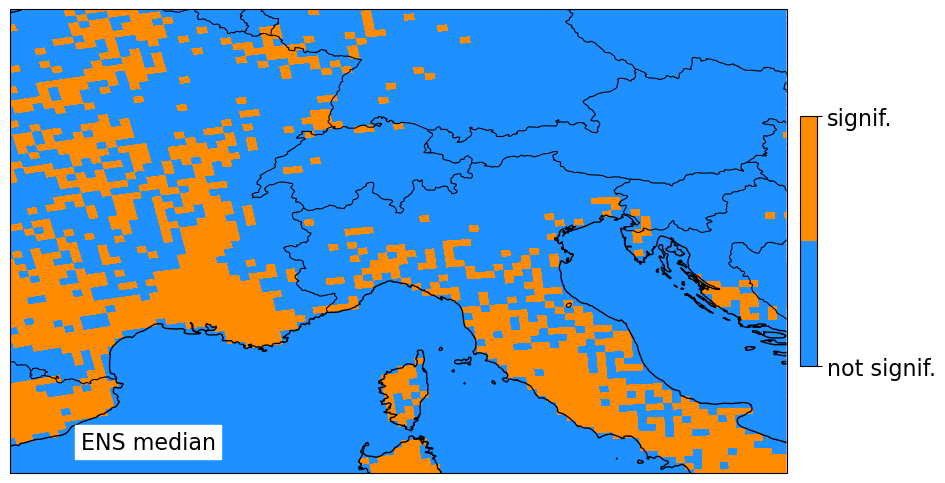

In [36]:
cmap = mcolors.ListedColormap(['dodgerblue', 'darkorange'])  # Black for > 0, white for <= 0
bounds = [-1, 1]  # Boundaries for color mapping
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Plot
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12, 7.2),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the composite array with the custom colormap
P1 = axes.pcolor(ds_his['lon'], ds_his['lat'], consensus_significant,cmap=cmap,transform=ccrs.PlateCarree())
# Add coastlines and other features
axes.coastlines(linewidth=1, color='black')
axes.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
axes.add_feature(cartopy.feature.BORDERS, linewidth=.8, color='black')
#axes.set_facecolor('red')
axes.text(2.45, 41, 'ENS median', fontsize=16, backgroundcolor='w', alpha=1)
#axes.set_title('CPRCMs ENS bias vs RCMs ENS bias (HWs mean Tmax)', fontsize=16, backgroundcolor='w', alpha=1)

cb = fig.colorbar(P1, ax=axes, orientation='vertical', aspect=15, shrink=.45, pad=.015)
cb.set_ticks([0, 1])  # Two ticks for the two regions (white and black)
cb.set_ticklabels(['not signif.', 'signif.'], fontsize=16)  # Custom labels

plt.show()


### Print netcdf

In [37]:
# Assuming 'results_all_models' is a 3D numpy array (models x lat x lon)
# and 'consensus_significant' is a 2D numpy array (lat x lon)

lat = ds_his.lat.values  # Replace with your actual latitude values
lon = ds_his.lon.values  # Replace with your actual longitude values
model_dim = np.arange(results_all_models.shape[0])  # Model dimension (0 to n_models-1)

# If lat and lon are 2D arrays, define them with different names to avoid conflicts
if lat.ndim == 2 and lon.ndim == 2:
    coords_3d = {
        "model": model_dim,
        "lat2d": (("lat", "lon"), lat),  # Use 'lat2d' for 2D latitude
        "lon2d": (("lat", "lon"), lon)   # Use 'lon2d' for 2D longitude
    }
    coords_2d = {
        "lat2d": (("lat", "lon"), lat),  # Use 'lat2d' for 2D latitude
        "lon2d": (("lat", "lon"), lon)   # Use 'lon2d' for 2D longitude
    }
else:
    coords_3d = {
        "model": model_dim,
        "lat": lat,  # Define 1D latitude array
        "lon": lon   # Define 1D longitude array
    }
    coords_2d = {
        "lat": lat,  # Define 1D latitude array
        "lon": lon   # Define 1D longitude array
    }

# Create xarray DataArray for the 3D results (models x lat x lon)
results_all_da = xr.DataArray(results_all_models, 
                              dims=["model", "lat", "lon"], 
                              coords=coords_3d, 
                              name="results_all_models")

# Create xarray DataArray for the 2D consensus results (lat x lon)
consensus_da = xr.DataArray(consensus_significant, 
                            dims=["lat", "lon"], 
                            coords=coords_2d, 
                            name="consensus_significant")

# Combine both DataArrays into a single Dataset
combined_ds = xr.Dataset({
    "results_all_models": results_all_da,
    "consensus_significant": consensus_da
})

# Save to a NetCDF file
combined_ds.to_netcdf(f'/users_home/cmcc/ls21622/tmp/monte_carlo_results_095_{res}_{var}.nc') 

print("Both 'results_all_models' and 'consensus_significant' saved to 'monte_carlo_results.nc'.")


Both 'results_all_models' and 'consensus_significant' saved to 'monte_carlo_results.nc'.
